In [1]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bin import utils

In [56]:
gdata = sc.read_h5ad('./RNA/spatial.combined.bin100.h5')
# fdata = sc.read_h5ad('./RNA/spatial.combined.clustered.h5')
fdata = sc.read_h5ad('./RNA/reclustered.h5')

In [57]:
gdata = gdata[:, gdata.var_names.str.startswith('sg')].copy()

In [58]:
fdata.obs['coord_x'] = fdata.obsm['spatial'][:, 0] // 100 * 100
fdata.obs['coord_y'] = fdata.obsm['spatial'][:, 1] // 100 * 100

gdata.obs['coord_x'] = gdata.obsm['spatial'][:, 0] // 100 * 100
gdata.obs['coord_y'] = gdata.obsm['spatial'][:, 1] // 100 * 100
fdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(fdata.obs['marker'], fdata.obs['coord_x'], fdata.obs['coord_y'])]
gdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(gdata.obs['marker'], gdata.obs['coord_x'], gdata.obs['coord_y'])]

common_bins = np.intersect1d(fdata.obs_names, gdata.obs_names)
fdata = fdata[common_bins].copy()
gdata = gdata[common_bins].copy()

In [59]:
gdata = utils.combine_guide_replicates(gdata)

/home/wpy/stereoseq/20240702-Exclusive/bin/utils.py:78: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [6]:
scdata = sc.read_h5ad('./RNA/sc.combined.dedup.clustered.h5')

In [6]:
scdata = sc.read_h5ad('./RNA/sc.combined.dedup.h5')

In [6]:
fdata_bin20 = sc.read_h5ad('./RNA/spatial.combined.bin20.h5')
fdata_bin20 = fdata_bin20[fdata_bin20.obs.marker == 'A'].copy()

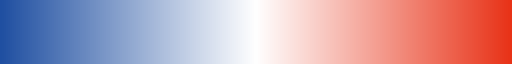

In [6]:
from types import new_class
from matplotlib.colors import LinearSegmentedColormap

colors = ['#1f4fa1', '#ffffff', '#e83217']
n_bins = 256
new_cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=n_bins)
new_cmap

# Phenotype <-> Distribution

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


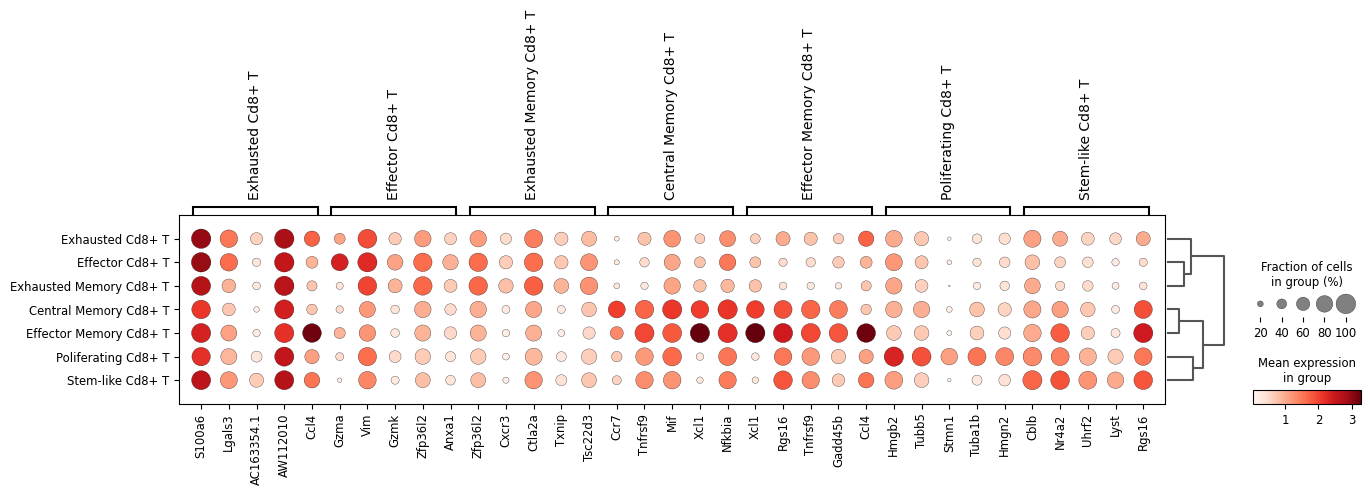

In [9]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

sc.tl.rank_genes_groups(scdata, groupby='leiden', method='t-test')
ax = sc.pl.rank_genes_groups_dotplot(scdata, n_genes=5, return_fig=True)
ax.show()

In [29]:
pval_cutoff = 0.01
top_n = 10

result = scdata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_genes_df = pd.DataFrame()

for group in groups:
    genes = result['names'][group]
    log2fc = result['logfoldchanges'][group]
    padj = result['pvals_adj'][group]
    score = result['scores'][group]
    
    data = pd.DataFrame({
        'Gene': genes,
        'Log2FoldChange': log2fc,
        'padj': padj,
        'score': score,
        'Cluster': group
    })
    
    filtered_data = data[data['padj'] < pval_cutoff]
    sorted_data = filtered_data.sort_values(by='score', ascending=False)
    top_genes = sorted_data.head(top_n)
    top_genes_df = pd.concat([top_genes_df, top_genes], ignore_index=True)

deg = top_genes_df["Gene"].unique().tolist()
top_genes_df

Gene  Log2FoldChange           padj      score                Cluster
0      Ccr7        3.479914  2.546920e-173  35.267666  Central Memory Cd8+ T
1   Tnfrsf9        1.685727  5.953150e-144  29.849846  Central Memory Cd8+ T
2       Mif        1.475150  1.459173e-141  29.723330  Central Memory Cd8+ T
3      Xcl1        2.405703  1.666246e-116  26.420259  Central Memory Cd8+ T
4    Nfkbia        1.209895  2.475211e-116  25.618769  Central Memory Cd8+ T
..      ...             ...            ...        ...                    ...
65  Ubash3b        1.844823  1.287146e-101  23.862261       Stem-like Cd8+ T
66    Stat3        1.234383  1.520594e-103  23.814705       Stem-like Cd8+ T
67   Filip1        1.958710   2.546966e-98  23.397350       Stem-like Cd8+ T
68     Lag3        1.285982  3.198715e-100  23.342068       Stem-like Cd8+ T
69  Tmem163        1.478730   1.503199e-91  22.297554       Stem-like Cd8+ T

[70 rows x 5 columns]

In [30]:
for t_type in top_genes_df.Cluster.unique():
    sc.tl.score_genes(fdata,
        gene_list=top_genes_df[top_genes_df.Cluster == t_type].Gene,
        score_name=t_type + '_score')

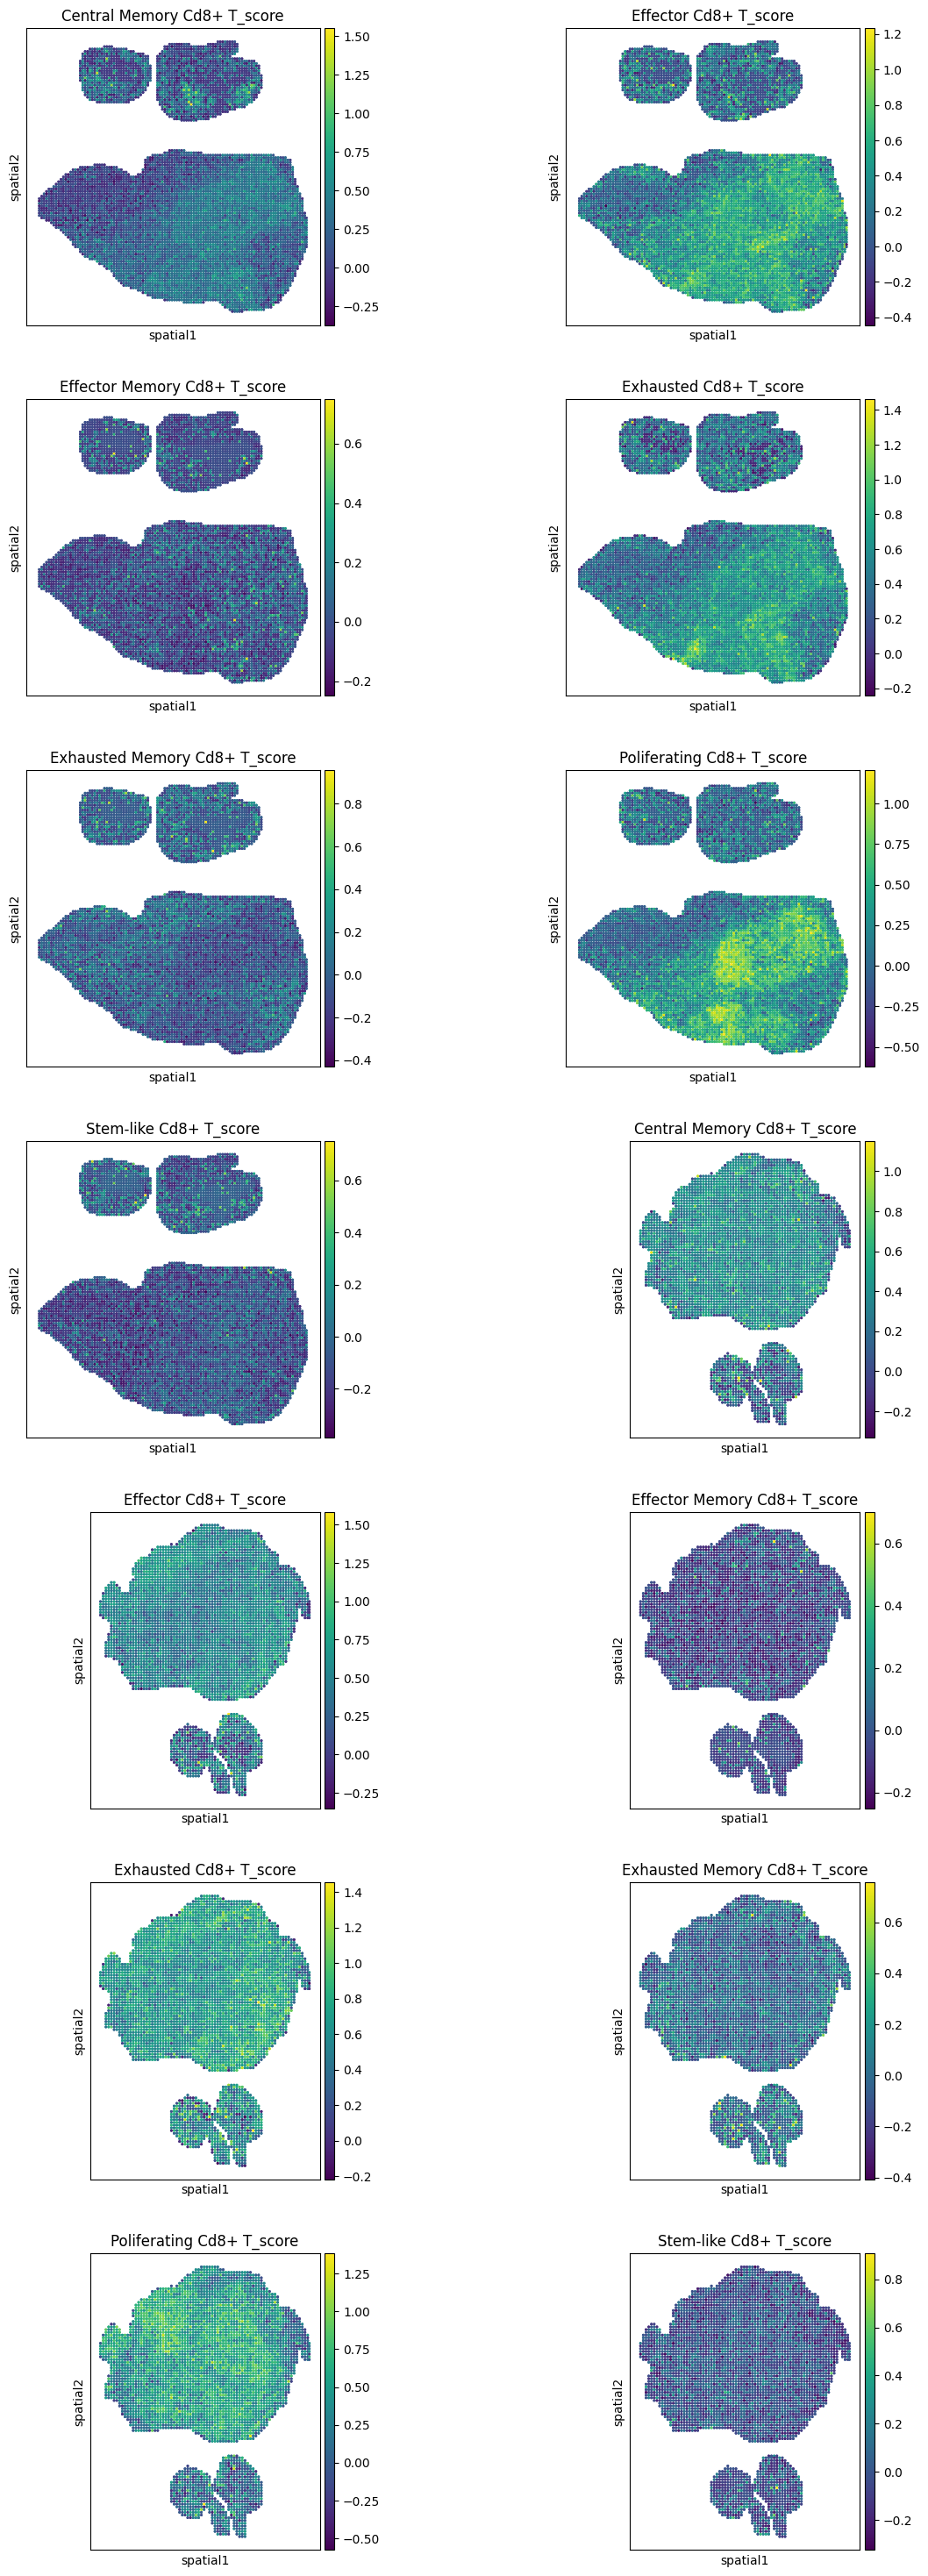

In [32]:
sq.pl.spatial_scatter(fdata,
    color=[t + '_score' for t in top_genes_df.Cluster.unique()],
    shape=None,
    size=5,
    library_key='marker',
    ncols=2)

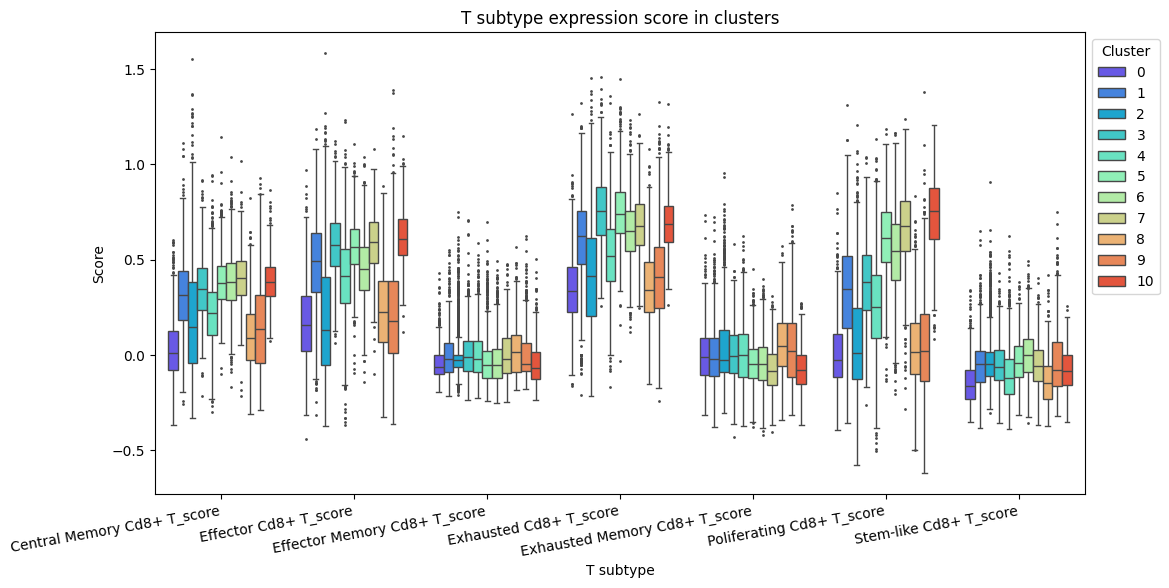

In [54]:
pdf = fdata.obs[['cluster'] + list(fdata.obs.columns[fdata.obs.columns.str.endswith('T_score')])].set_index('cluster').melt(ignore_index=False).reset_index()
plt.figure(figsize=(12, 6))
sns.boxplot(pdf, x='variable', hue='cluster', y='value', palette='rainbow', fliersize=1)
plt.ylabel('Score')
plt.xlabel('T subtype')
plt.xticks(rotation=10, ha='right')
plt.title('T subtype expression score in clusters')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1))
plt.show()

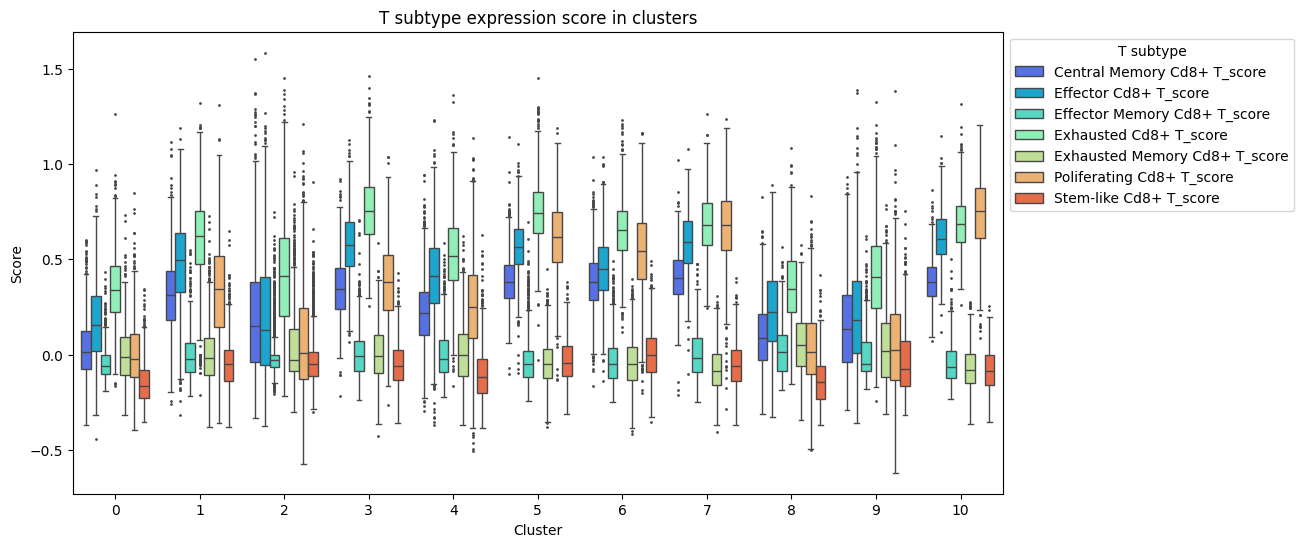

In [55]:
pdf = fdata.obs[['cluster'] + list(fdata.obs.columns[fdata.obs.columns.str.endswith('T_score')])].set_index('cluster').melt(ignore_index=False).reset_index()
plt.figure(figsize=(12, 6))
sns.boxplot(pdf, x='cluster', hue='variable', y='value', palette='rainbow', fliersize=1)
plt.ylabel('Score')
plt.xlabel('Cluster')
plt.title('T subtype expression score in clusters')
plt.legend(title='T subtype', bbox_to_anchor=(1, 1))
plt.show()

# Chemokine Receptor <-> Distribution

In [7]:
gsea_chemokine_rc = ["Ackr2", "Ackr3", "Ackr4", "Ccl1", "Ccl11", "Ccl12", "Ccl17", "Ccl19",
    "Ccl20", "Ccl21a", "Ccl21b", "Ccl21d", "Ccl21e", "Ccl21f", "Ccl22", "Ccl25", "Ccl27a", "Ccl27al",
    "Ccl27b", "Ccl28", "Ccl3", "Ccl4", "Ccl5", "Ccr10", "Ccr3", "Ccr4", "Ccr5", "Ccr6", "Ccr7", "Ccr8",
    "Ccr9", "Ccrl2", "Cx3cl1", "Cx3cr1", "Cxcl1", "Cxcl10", "Cxcl11", "Cxcl12", "Cxcl13", "Cxcl16",
    "Cxcl2", "Cxcl3", "Cxcl5", "Cxcl9", "Cxcr1", "Cxcr2", "Cxcr3", "Cxcr4", "Cxcr5", "Cxcr6",
    "Pf4", "Ppbp", "Xcl1", "Xcr1"]
gsea_chemokine_rc = np.array(gsea_chemokine_rc)[np.isin(gsea_chemokine_rc, fdata.var_names)]

In [8]:
from scipy.spatial import distance_matrix
import seaborn as sns

In [54]:
def plot_lr_interaction(fdata, ligand, receptor, ax=None, alpha=0.9, bw_adjust=0.6):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(8, 4))

    ax.set_facecolor('black')
    sns.scatterplot(x=fdata.obsm['spatial'][:, 0], y=fdata.obsm['spatial'][:, 1],
                    s=fdata[:, ligand].X.toarray().flatten() * 10, color='White', ax=ax, alpha=0.2, legend=False, label=ligand)
    sns.scatterplot(x=fdata.obsm['spatial'][:, 0], y=fdata.obsm['spatial'][:, 1],
                    s=fdata[:, receptor].X.toarray().flatten() * 10, color='Aqua', ax=ax, alpha=0.2, legend=False, label=receptor)

    lig_coords = fdata[fdata[:, ligand].X > 0].obsm['spatial']
    rec_coords = fdata[fdata[:, receptor].X > 0].obsm['spatial']

    dist_matrix = distance_matrix(lig_coords, rec_coords)

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.grid(True, color='gray')
    ax.set_title(f'{ligand} ~ {receptor} Interaction Strength')
    
    if (dist_matrix < 30).sum() == 0: return
    # kde = sns.kdeplot(ax=ax, x=rec_coords[:, 0], y=rec_coords[:, 1], weights=np.array((dist_matrix < 50).sum(axis=0)),
    #             fill=True, cmap='viridis', bw_adjust=bw_adjust, alpha=alpha, levels=50, cbar=True)
    # norm = plt.Normalize(vmin=kde.get_array().min(), vmax=kde.get_array().max())
    # sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    # sm.set_array([])
    # cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Interaction Strength')
    # cbar = plt.colorbar(kde, ax=ax, orientation='vertical', label='Interaction Strength')
    # cbar.set_label('Interaction Strength', rotation=270, labelpad=15)

    legend = ax.legend(loc='upper left', title='', frameon=False)
    legend.get_frame().set_facecolor('black')
    plt.setp(legend.get_texts(), color='white')

In [62]:
# fdata_ = fdata[(fdata.obs.marker == 'A') & (fdata.obsm['spatial'][:, 1] > 4000)]
fdata_ = fdata[fdata.obs.marker == 'A'].copy()

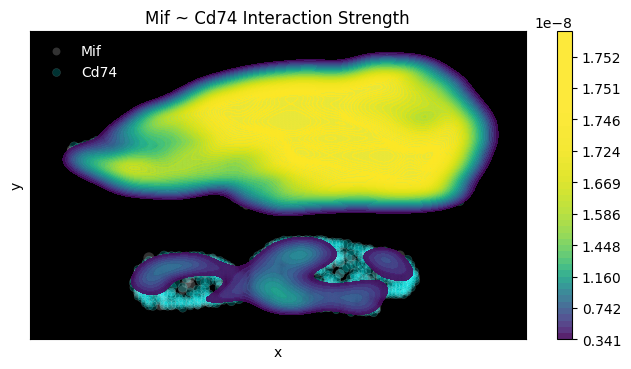

In [22]:
_, ax = plt.subplots(1, 1, figsize=(8, 4))
plot_lr_interaction(fdata_, 'Mif', 'Cd74', ax=ax)

In [76]:
# lr_pairs = [
#     ('Ccr10', 'Ccl27a'), ('Ccr10', 'Ccl28'), ('Ccr6', 'Ccl20'), ('Ccr7', 'Ccl19'),
#     ('Ccr9', 'Ccl19'), ('Ccr9', 'Ccl21a'), ('Ccr9', 'Ccl25'), ('Cx3cr1', 'Cx3cl1'),
#     ('Cxcr2', 'Cxcl1'), ('Cxcr3', 'Cxcl9'), ('Ccrl2', 'Ccl19'),
#     ('Cxcr2', 'Cxcl2'), ('Cxcr2', 'Cxcl3'), ('Cxcr2', 'Cxcl5'), ('Cxcr3', 'Cxcl9'), ('Cxcr3', 'Cxcl10'),
#     ('Cxcr4', 'Cxcl12'), ('Cxcr5', 'Cxcl13'), ('Cxcr6', 'Cxcl16'), ('Ccr3', 'Ccl5'),
#     ('Ccr4', 'Ccl5'), ('Ccr5', 'Ccl5'), ('Ackr2', 'Ccl1'), ('Ackr2', 'Ccl3'), ('Ackr2', 'Ccl4'),
#     ('Ackr2', 'Ccl19'), ('Ackr2', 'Ccl5'), ('Ackr2', 'Ccl25'),
#     ('Ackr2', 'Ccl11'), ('Ackr2', 'Ccl12'), ('Ackr2', 'Ccl28'), ('Ackr2', 'Ccl27a'),
# ]
lr_pairs = [
    ('Xcr1', 'Xcl1'), ('Cx3cr1', 'Cx3cl1'), ('Cxcr6', 'Cxcl16'), ('Cxcr5', 'Cxcl13'), ('Cxcr4', 'Cxcl14'),
    ('Cxcr4', 'Cxcl12'), ('Cxcr3', 'Cxcl9'), ('Cxcr3', 'Cxcl10'), ('Cxcr2', 'Cxcl5'), ('Cxcr2', 'Cxcl1'),
    ('Ccr9', 'Ccl25'), ('Ccr7', 'Ccl19'), ('Ccr6', 'Ccl20'), ('Ccr5', 'Ccl5'), ('Ccr4', 'Ccl5'), ('Ccr3', 'Ccl5'),
    ('Ackr3', 'Cxcl12'), ('Ackr4', 'Ccl19')
][::-1]
print(len(lr_pairs))

18


18it [00:02,  7.81it/s]


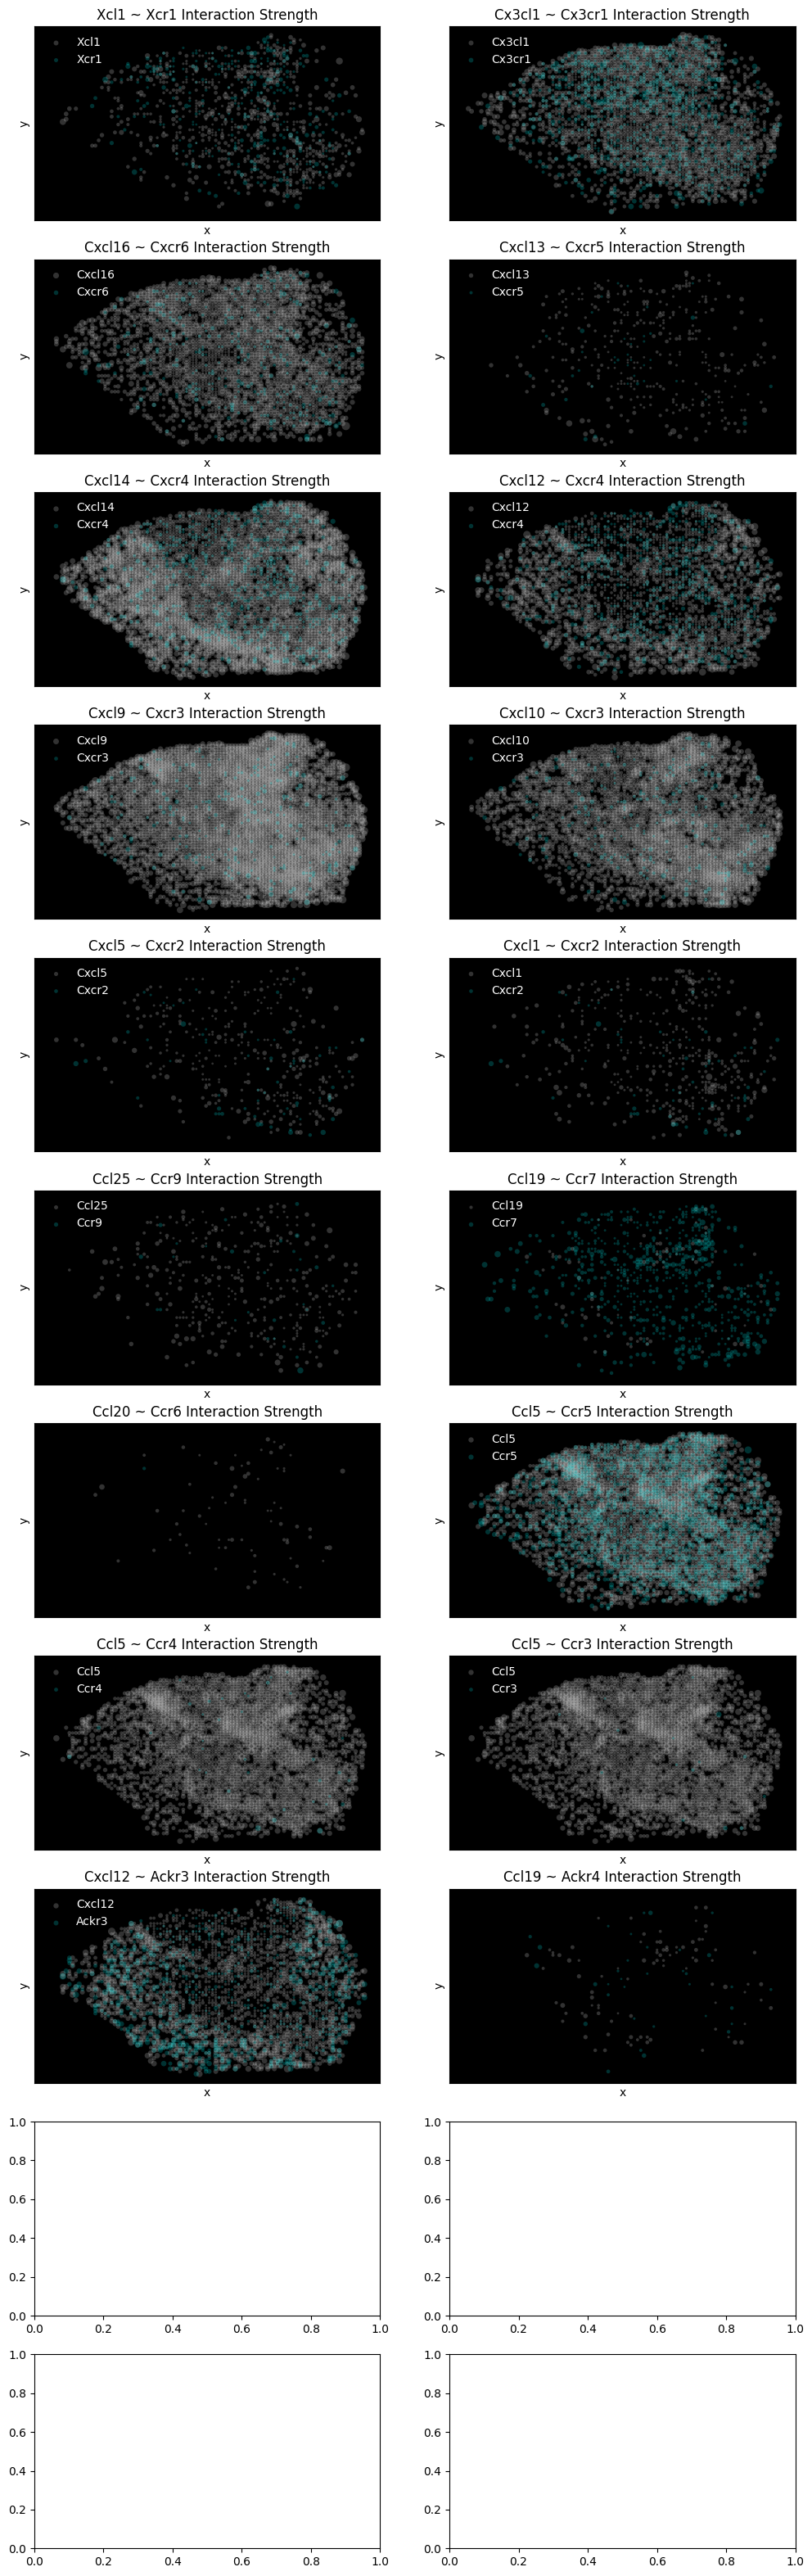

In [63]:
from tqdm import tqdm

_, axs = plt.subplots(11, 2, figsize=(12, 40))
for idx, lr in tqdm(enumerate(lr_pairs)):
    ax = axs[idx // 2, idx % 2]
    # try:
    plot_lr_interaction(fdata_, lr[1], lr[0], ax=ax)
    # except:
        # print(lr)

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('chemokine_receptor_interaction_kde.pdf', bbox_inches='tight')
plt.show()

In [30]:
gdata_ = gdata[gdata.obs.marker == 'A'].copy()

In [31]:
import numpy as np
import statsmodels.api as sm

# Calculate guide distribution in each cluster
guide = 'sgBhlhe40'
dist_m_guide = np.zeros([len(lr_pairs), 20])
guide_coords = gdata_[gdata_[:, guide].X.flatten() > 0].obsm['spatial']
for idx, (ligand, receptor) in tqdm(enumerate(lr_pairs)):
    lig_coords = fdata_[fdata_[:, ligand].X > 0].obsm['spatial']
    rec_coords = fdata_[fdata_[:, receptor].X > 0].obsm['spatial']

    dist_matrix = distance_matrix(lig_coords, rec_coords)
    interact_matrix = (dist_matrix < 50).sum(axis=0)

    guide_dist_matrix = distance_matrix(guide_coords, rec_coords[interact_matrix > 0])

    for distance in np.arange(0, 200, 10):
        guide_interact_matrix = (guide_dist_matrix < distance).sum(axis=1)
        dist_m_guide[idx, distance // 10] = (guide_interact_matrix > 0).sum() / guide_interact_matrix.shape[0]

dist_df_guide = pd.DataFrame(dist_m_guide, index=lr_pairs, columns=np.arange(0, 200, 10))

0it [00:00, ?it/s]


NameError: name 'distance_matrix' is not defined

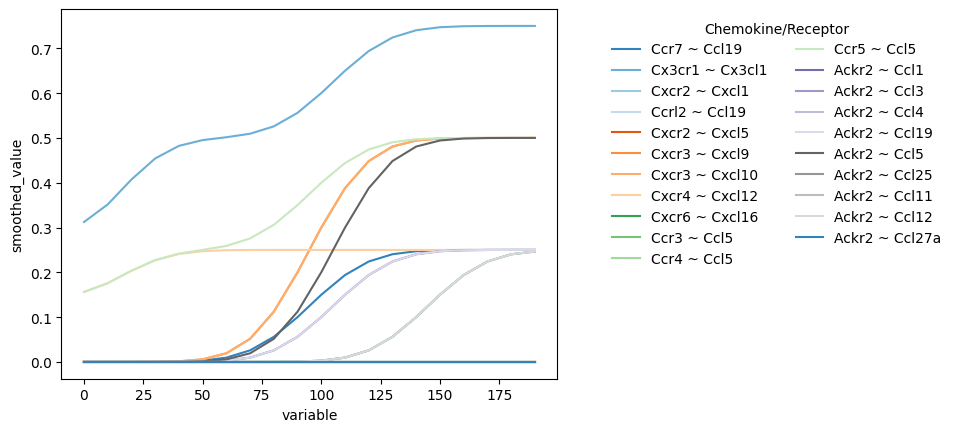

In [297]:
from scipy.ndimage import gaussian_filter1d

m_df = dist_df_guide.melt(ignore_index=False).reset_index()
m_df['index'] = m_df['index'].apply(lambda x: f"{x[0]} ~ {x[1]}")

for pair in m_df['index'].unique():
    mask = (m_df['index'].str.split(' ~ ').str[0] == pair.split(' ~ ')[0]) & (m_df['index'].str.split(' ~ ').str[1] == pair.split(' ~ ')[1])
    m_df.loc[mask, 'smoothed_value'] = gaussian_filter1d(m_df.loc[mask, 'value'], sigma=2)

sns.lineplot(m_df, x='variable', y='smoothed_value', hue='index', palette='tab20c')

plt.legend(title='Chemokine/Receptor', bbox_to_anchor=(1.8, 1), frameon=False, loc='upper right', ncol=2)
plt.show()

In [298]:
import numpy as np
import statsmodels.api as sm

# Calculate guide distribution in each cluster
guide = 'sgnon-targeting'
dist_m_ntc = np.zeros([len(lr_pairs), 20])
guide_coords = gdata_[gdata_[:, guide].X.flatten() > 0].obsm['spatial']
for idx, (ligand, receptor) in tqdm(enumerate(lr_pairs)):
    lig_coords = fdata_[fdata_[:, ligand].X > 0].obsm['spatial']
    rec_coords = fdata_[fdata_[:, receptor].X > 0].obsm['spatial']

    dist_matrix = distance_matrix(lig_coords, rec_coords)
    interact_matrix = (dist_matrix < 50).sum(axis=0)

    guide_dist_matrix = distance_matrix(guide_coords, rec_coords[interact_matrix > 0])

    for distance in np.arange(0, 200, 10):
        guide_interact_matrix = (guide_dist_matrix < distance).sum(axis=1)
        dist_m_ntc[idx, distance // 10] = (guide_interact_matrix > 0).sum() / guide_interact_matrix.shape[0]

dist_df_ntc = pd.DataFrame(dist_m_ntc, index=lr_pairs, columns=np.arange(0, 200, 10))

21it [00:05,  3.58it/s]


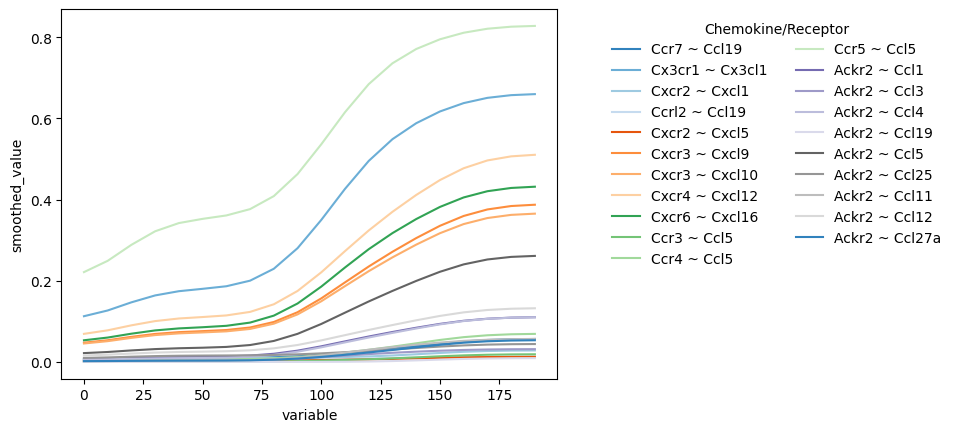

In [299]:
from scipy.ndimage import gaussian_filter1d

m_df = dist_df_ntc.melt(ignore_index=False).reset_index()
m_df['index'] = m_df['index'].apply(lambda x: f"{x[0]} ~ {x[1]}")

for pair in m_df['index'].unique():
    mask = (m_df['index'].str.split(' ~ ').str[0] == pair.split(' ~ ')[0]) & (m_df['index'].str.split(' ~ ').str[1] == pair.split(' ~ ')[1])
    m_df.loc[mask, 'smoothed_value'] = gaussian_filter1d(m_df.loc[mask, 'value'], sigma=2)

sns.lineplot(m_df, x='variable', y='smoothed_value', hue='index', palette='tab20c')

plt.legend(title='Chemokine/Receptor', bbox_to_anchor=(1.8, 1), frameon=False, loc='upper right', ncol=2)
plt.show()

In [32]:
m_df = dist_df_ntc.melt(ignore_index=False).reset_index()
m_df['index'] = m_df['index'].apply(lambda x: f"{x[0]} ~ {x[1]}")
m_df['guide'] = 'sgnon-targeting'
c_df = dist_df_guide.melt(ignore_index=False).reset_index()
c_df['index'] = c_df['index'].apply(lambda x: f"{x[0]} ~ {x[1]}")
c_df['guide'] = 'sgBhlhe40'
m_df = pd.concat([m_df, c_df], axis=0)
m_df

NameError: name 'dist_df_ntc' is not defined

/tmp/ipykernel_34001/4148609488.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.loc[mask, 'smoothed_value'] = gaussian_filter1d(plot_df.loc[mask, 'value'], sigma=2)


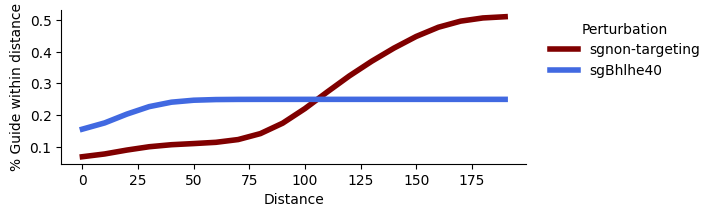

In [308]:
plot_df = m_df[m_df['index'] == 'Cxcr4 ~ Cxcl12']

plt.figure(figsize=(6, 2))
for guide in plot_df['guide'].unique():
    mask = plot_df['guide'] == guide
    plot_df.loc[mask, 'smoothed_value'] = gaussian_filter1d(plot_df.loc[mask, 'value'], sigma=2)

sns.lineplot(plot_df, x='variable', y='smoothed_value', hue='guide', palette=['maroon', 'royalblue'], linewidth=4)

plt.legend(title='Perturbation', bbox_to_anchor=(1.4, 1), frameon=False, loc='upper right', ncol=1)
sns.despine()
# plt.xlim([-1, 75])
plt.xlabel('Distance')
plt.ylabel('% Guide within distance')

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('chemokine_receptor_interaction_proportion.pdf', bbox_inches='tight', format='pdf')
plt.show()

18it [00:02,  6.85it/s]


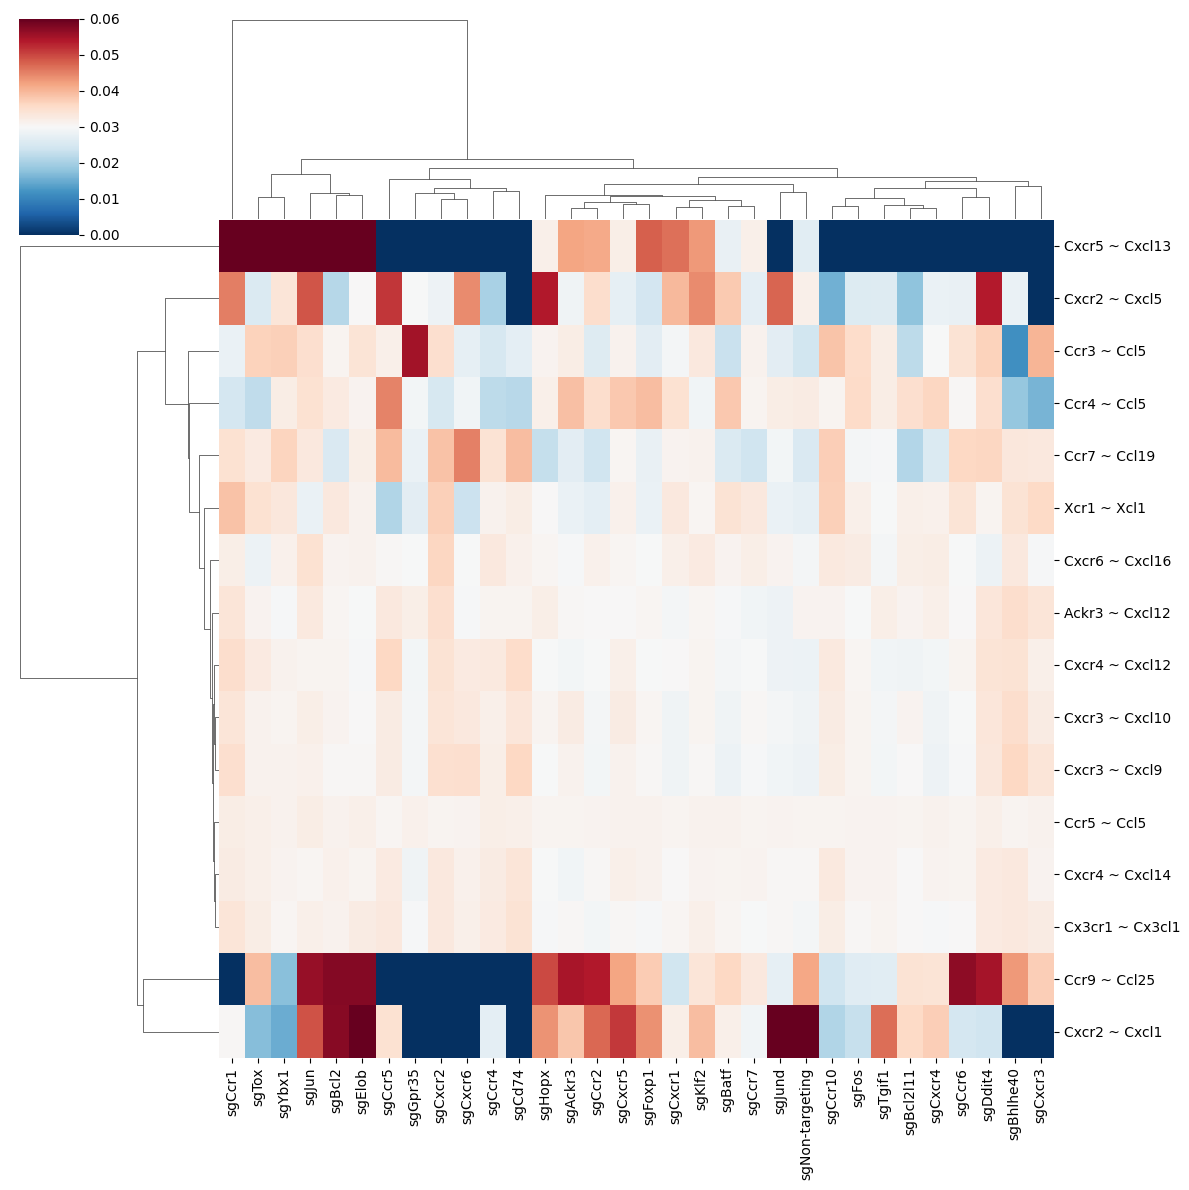

In [120]:
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm
from scipy.spatial import distance_matrix

fdata_ = fdata[(fdata.obs.marker == 'A') & (fdata.obsm['spatial'][:, 1] > 4000)].copy()
gdata_ = gdata[(gdata.obs.marker == 'A') & (gdata.obsm['spatial'][:, 1] > 4000)].copy()

# fdata_ = fdata[(fdata.obs.marker == 'B') & (fdata.obsm['spatial'][:, 1] < 6500)].copy()
# gdata_ = gdata[(gdata.obs.marker == 'B') & (gdata.obsm['spatial'][:, 1] < 6500)].copy()

# Calculate guide distribution in each cluster
dist_m_guide = np.zeros([len(lr_pairs), len(gdata_.var_names)])
for idx, (ligand, receptor) in tqdm(enumerate(lr_pairs)):
    lig_coords = fdata_[fdata_[:, ligand].X > 0].obsm['spatial']
    rec_coords = fdata_[fdata_[:, receptor].X > 0].obsm['spatial']
    dist_matrix = distance_matrix(lig_coords, rec_coords)
    interact_matrix = (dist_matrix < 10).sum(axis=1)
    for i_guide, guide in enumerate(gdata_.var_names):
        guide_coords = gdata_[gdata_[:, guide].X.flatten() > 0].obsm['spatial']

        guide_dist_matrix = distance_matrix(guide_coords, lig_coords[interact_matrix > 0])

        guide_interact_matrix = (guide_dist_matrix < 150).sum(axis=1)
        dist_m_guide[idx, i_guide] = (guide_interact_matrix > 0).sum() / guide_interact_matrix.shape[0]

dist_df_guide = pd.DataFrame(dist_m_guide, index=lr_pairs, columns=gdata_.var_names)

dist_df = dist_df_guide.copy()
dist_df.index = dist_df.index.map(lambda x: x[0] + ' ~ ' + x[1])
dist_df.index
# dist_df = dist_df.div(dist_df.sum(axis=0), axis=1)
dist_df = dist_df.div(dist_df.sum(axis=1), axis=0)
# dist_df = dist_df.loc[:, ~(dist_df.columns.str.startswith('sgCcr5') | dist_df.columns.str.startswith('sgCcr2'))]
dist_df = dist_df.dropna()
sns.clustermap(dist_df, figsize=(12, 12), cmap='RdBu_r', vmax=0.06, vmin=0)

1.0 1.2718425942576277
Xcr1 ~ Xcl1
Cx3cr1 ~ Cx3cl1
Cxcr6 ~ Cxcl16
Cxcr5 ~ Cxcl13
Cxcr4 ~ Cxcl14
Cxcr4 ~ Cxcl12
Cxcr3 ~ Cxcl9
Cxcr3 ~ Cxcl10
Cxcr2 ~ Cxcl5
Cxcr2 ~ Cxcl1
Ccr9 ~ Ccl25
Ccr7 ~ Ccl19
Ccr5 ~ Ccl5
Ccr4 ~ Ccl5
Ccr3 ~ Ccl5
Ackr3 ~ Cxcl12


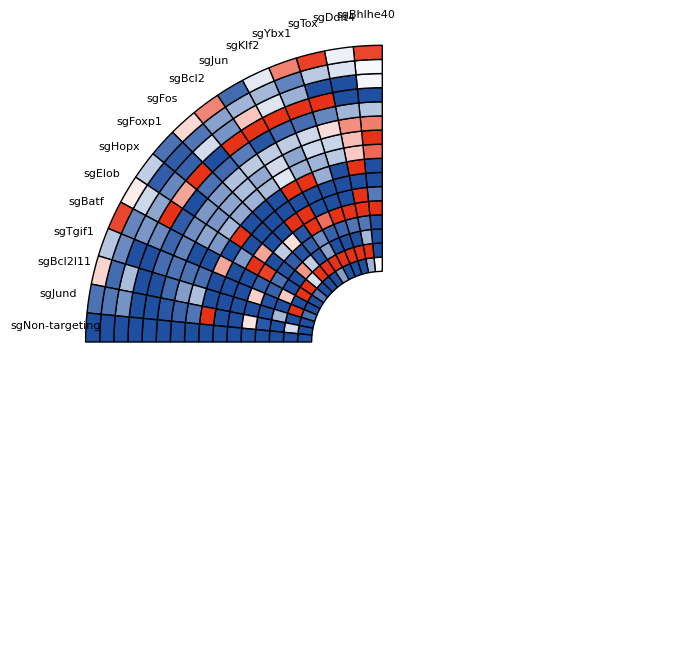

In [128]:
chemokine_list = ["sgCcr1", "sgCcr2", "sgCcr4", "sgCcr5", "sgCcr6",
    "sgCcr7", "sgCcr10", "sgCxcr1", "sgCxcr2", "sgCxcr3", "sgCxcr4",
    "sgAckr3", "sgCxcr5", "sgCxcr6", "sgCd74", "sgGpr35", 'sgnon-targeting']
tf_list = [x for x in dist_df.columns if x not in chemokine_list]

plot_df = dist_df.loc[:, tf_list]

plot_df = plot_df.map(lambda x: x if x < 0.1 else 0.1)
plot_df = plot_df.div(plot_df['sgNon-targeting'], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': 'polar'})
cmap = new_cmap
# cmap = new_cmap

sorted_guides = plot_df.columns[np.argsort(plot_df.loc['Cxcr4 ~ Cxcl12', :].values)[::-1]]

min_val = np.min(plot_df.loc['Cxcr4 ~ Cxcl12', :].values)
max_val = np.max(plot_df.loc['Cxcr4 ~ Cxcl12', :].values) + 0.05
print(min_val, max_val)
plot_df = plot_df.clip(min_val, max_val)

radius = 1
width = 0.2

angle = 0.5 * np.pi / len(plot_df.columns)
angles = np.linspace(0.5 * np.pi + angle / 2, 1 * np.pi + angle / 2, len(plot_df.columns), endpoint=False)

for cluster in ['None'] * 0 + list(plot_df.index):
    if cluster != 'None':
        guide_colors = cmap(((plot_df.loc[cluster, sorted_guides].values - min_val) / (max_val - min_val)))
        bars = ax.bar(x=angles, height=width, width=angle, color=guide_colors, edgecolor='black', bottom=radius, alpha=1)  # 添加黑色网框
    else: 
        bars = ax.bar(x=angles, height=width, width=angle, color='none', edgecolor='black', bottom=radius)  # 添加黑色网框
    radius = radius + width
for cluster in list(plot_df.index)[::-1]:
    print(cluster)

ax.spines['polar'].set_visible(False)  # 去除边框
ax.set_xticks(angles, sorted_guides, rotation=0, ha='center', fontsize=8)
ax.set_yticks([])
ax.grid(False)  # 去除grid线

# plt.xlim([0.5 * np.pi, 2 * np.pi])
# plt.ylim([0, 1])
plt.rcParams['pdf.fonttype']=42
plt.savefig("./plots/sgTF_interaction_radar.pdf", format="pdf", bbox_inches='tight')
plt.show()

Ackr2 ~ Ccl27a
Ackr2 ~ Ccl12
Ackr2 ~ Ccl11
Ackr2 ~ Ccl25
Ackr2 ~ Ccl5
Ackr2 ~ Ccl19
Ackr2 ~ Ccl4
Ackr2 ~ Ccl3
Ackr2 ~ Ccl1
Ccr5 ~ Ccl5
Ccr4 ~ Ccl5
Ccr3 ~ Ccl5
Cxcr6 ~ Cxcl16
Cxcr4 ~ Cxcl12
Cxcr3 ~ Cxcl10
Cxcr3 ~ Cxcl9
Cxcr2 ~ Cxcl5
Ccrl2 ~ Ccl19
Cxcr2 ~ Cxcl1
Cx3cr1 ~ Cx3cl1
Ccr7 ~ Ccl19


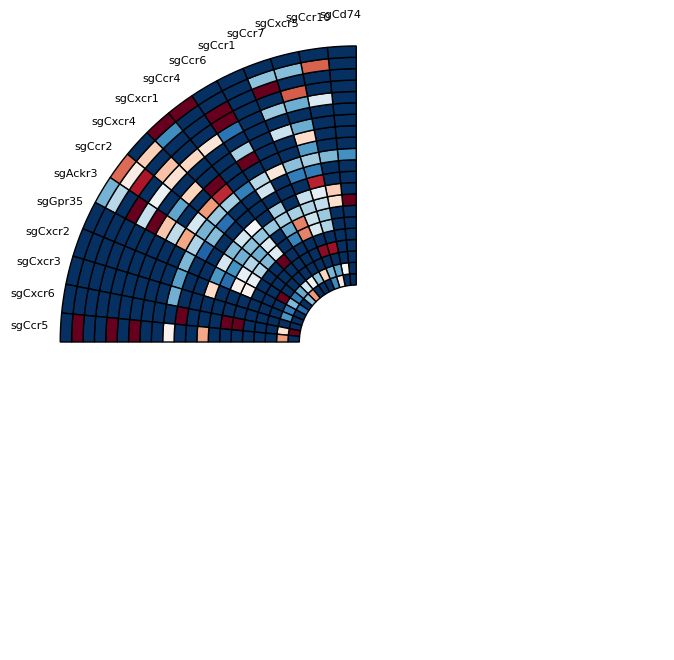

In [425]:
chemokine_list = ["sgCcr1", "sgCcr2", "sgCcr4", "sgCcr5", "sgCcr6",
    "sgCcr7", "sgCcr10", "sgCxcr1", "sgCxcr2", "sgCxcr3", "sgCxcr4",
    "sgAckr3", "sgCxcr5", "sgCxcr6", "sgCd74", "sgGpr35"]

plot_df = dist_df.loc[:, chemokine_list]

plot_df = plot_df.map(lambda x: x if x < 0.1 else 0.1)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': 'polar'})
cmap = plt.colormaps['RdBu_r']

sorted_guides = plot_df.columns[np.argsort(plot_df.loc['Cxcr4 ~ Cxcl12', :].values)[::-1]]

min_val = np.min(plot_df.values)
max_val = np.max(plot_df.values)

radius = 1
width = 0.2

angle = 0.5 * np.pi / len(plot_df.columns)
angles = np.linspace(0.5 * np.pi + angle / 2, 1 * np.pi + angle / 2, len(plot_df.columns), endpoint=False)

for cluster in ['None'] * 0 + list(plot_df.index):
    if cluster != 'None':
        guide_colors = cmap(((plot_df.loc[cluster, sorted_guides].values - min_val) / (max_val - min_val)))
        bars = ax.bar(x=angles, height=width, width=angle, color=guide_colors, edgecolor='black', bottom=radius, alpha=1)  # 添加黑色网框
    else: 
        bars = ax.bar(x=angles, height=width, width=angle, color='none', edgecolor='black', bottom=radius)  # 添加黑色网框
    radius = radius + width
for cluster in list(plot_df.index)[::-1]:
    print(cluster)

ax.spines['polar'].set_visible(False)  # 去除边框
ax.set_xticks(angles, sorted_guides, rotation=0, ha='center', fontsize=8)
ax.set_yticks([])
ax.grid(False)  # 去除grid线

# plt.xlim([0.5 * np.pi, 2 * np.pi])
# plt.ylim([0, 1])
# plt.rcParams['pdf.fonttype']=42
plt.savefig("./plots/sgCR_interaction_radar.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [193]:
sq.gr.spatial_neighbors(fdata_, coord_type='generic', library_key='marker', delaunay=False, set_diag=True, radius=250)
sq.gr.spatial_autocorr(fdata_, genes=gsea_chemokine_rc)

# Phenotype <-> Chemokine Receptor

In [10]:
import libpysal.weights.distance as lwd
from splot.esda import moran_scatterplot
from esda.moran import Moran_BV, Moran_Local_BV

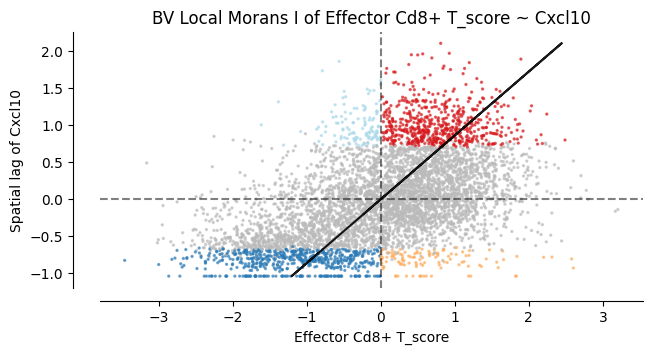

In [341]:
gene = 'Cxcl10'
score = 'Effector Cd8+ T_score'

y_matrix = fdata_[:, gene].X.toarray().flatten().tolist()
t_matrix = fdata_.obs[score]
w_matrix = lwd.DistanceBand.from_array(fdata_.obsm['spatial'], threshold=150)

moran_loc_bv = Moran_Local_BV(t_matrix, y_matrix, w_matrix)
fig, ax = moran_scatterplot(moran_loc_bv, p=0.01, zstandard=True, scatter_kwds={'s': 2})
ax.set_title(f'BV Local Morans I of {score} ~ Cxcl10')
ax.set_xlabel(score)
ax.set_ylabel(f'Spatial lag of {gene}')
plt.show()

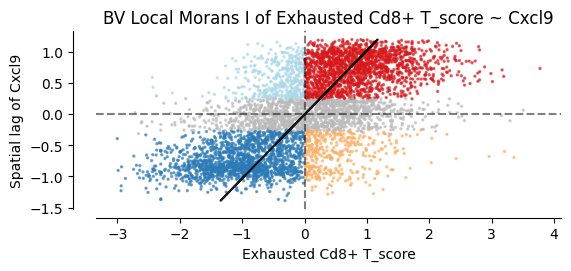

In [290]:
gene = 'Cxcl9'
score = 'Exhausted Cd8+ T_score'

y_matrix = fdata_[:, gene].X.toarray().flatten().tolist()
t_matrix = fdata_.obs[score]
w_matrix = lwd.DistanceBand.from_array(fdata_.obsm['spatial'], threshold=550)

moran_loc_bv = Moran_Local_BV(t_matrix, y_matrix, w_matrix)
fig, ax = moran_scatterplot(moran_loc_bv, p=0.01, scatter_kwds={'s': 2})
fig.set_figwidth(6)
fig.set_figheight(6)
ax.set_title(f'BV Local Morans I of {score} ~ {gene}')
ax.set_xlabel(score)
ax.set_ylabel(f'Spatial lag of {gene}')
plt.show()

In [14]:
p_matrix = np.zeros([len(gsea_chemokine_rc), len(fdata_.obs.filter(regex='.*T_score').columns)])

from scipy.stats import spearmanr
for i, chem in enumerate(gsea_chemokine_rc):
    for j, score in enumerate(fdata_.obs.filter(regex='.*T_score').columns):
        p_matrix[i, j] = spearmanr(fdata_[:, chem].X.toarray().flatten().tolist(), fdata_.obs[score].tolist()).pvalue

In [15]:
rdf = pd.DataFrame(p_matrix, index=gsea_chemokine_rc, columns=fdata_.obs.filter(regex='.*T_score').columns)

/tmp/ipykernel_28112/429145992.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(sig_df, x='moranI', y='score', hue='t_subtype', palette='Reds')
/tmp/ipykernel_28112/429145992.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(pdf, x='moranI', y='score', hue='t_subtype', ax=ax, alpha=0.05, palette='Greys', legend=False)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


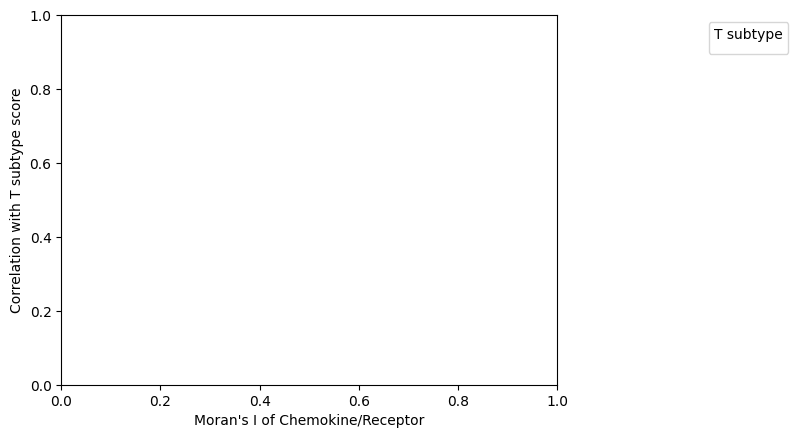

In [16]:
pdf = pd.DataFrame(columns=['moranI', 'score', 't_subtype'])
for score in rdf.columns:
    df = pd.concat([rdf[score], fdata_.uns['moranI']['I']], axis=1)
    df.columns = ['moranI', 'score']
    df['t_subtype'] = score.rstrip('_score')
    pdf = pd.concat([pdf, df])

sig_df = pdf[(pdf.moranI > 0.05) & (pdf.score > 0.1)]
ax = sns.scatterplot(sig_df, x='moranI', y='score', hue='t_subtype', palette='Reds')
sns.scatterplot(pdf, x='moranI', y='score', hue='t_subtype', ax=ax, alpha=0.05, palette='Greys', legend=False)

from adjustText import adjust_text
texts = []
for i, point in sig_df.iterrows():
    texts.append(plt.text(point['moranI'], point['score'], str(i), size=7))

adjust_text(texts, expand_axes=True)
plt.ylabel('Correlation with T subtype score')
plt.xlabel("Moran's I of Chemokine/Receptor")
plt.legend(title='T subtype', loc="upper right", bbox_to_anchor=(1.48, 1))
plt.show()